# 6-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기
- 이전 스텝까지는 영문 텍스트의 감정 분석을 진행해 보았습니다. 
- 그렇다면 이번에는 한국어 텍스트의 감정 분석을 진행해 보면 어떨까요? 
- 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus(https://github.com/e9t/nsmc) 입니다.

## 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

- nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 
- 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. 
- data_loader 안에서는 다음을 수행해야 합니다.

  - 데이터의 중복 제거
  - NaN 결측치 제거
  - 한국어 토크나이저로 토큰화
  - 불용어(Stopwords) 제거
  - 사전word_to_index 구성
  - 텍스트 스트링을 사전 인덱스 스트링으로 변환
  - x_train, y_train, x_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


### 데이터 로드

In [3]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
print("- 훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))
print("- 1번째 리뷰데이터: ", x_train[0])  # 1번째 리뷰데이터
print('- 1번째 리뷰데이터의 라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('- 1번째 리뷰 문장 길이: ', len(x_train[0]))
print('- 2번째 리뷰 문장 길이: ', len(x_train[1]))
print("- word_to_index 크기: ", len(word_to_index))

- 훈련 샘플 개수: 146182, 테스트 개수: 49157
- 1번째 리뷰데이터:  [32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
- 1번째 리뷰데이터의 라벨:  0
- 1번째 리뷰 문장 길이:  10
- 2번째 리뷰 문장 길이:  17
- word_to_index 크기:  9997


In [5]:
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
word_to_index['<PAD>'] = 0
word_to_index['<BOS>'] = 1
word_to_index['<UNK>'] = 2

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

index_to_word

{3: '',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95: '시간',
 96: '지루',
 97: '중',
 98: '재미있',
 99: '

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

- encode된 텍스트가 정상적으로 decode 되는지 확인

In [8]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포 확인
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [9]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


- 이 경우 maxlen = 41

### Padding 추가 
- 문장 뒤쪽('post'): RNN을 이용한 딥러닝 적용 시 성능 차이 발생. 'post'가 훨씬 유리 (10% 이상의 성능 차이)

In [10]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


## 4) Validation Set 구성
####  model 훈련 전에, 훈련용 데이터셋 146,181건 중 39,068건을 분리하여 검증셋(validation set)으로 사용 
- 총 데이터 수: 195,339 (= 훈련용 146,182 + 테스트용 49,157)
- 테스트 데이터셋 비율 25% (= 49,157/195,339)
- 적절한 validation 데이터 비율로 전체 데이터셋의 20% 사용
  - 195,339 * 20% = 39,068 
- (최종 데이터셋 비율) 훈련용 107,114 (55%), 검증용 39,068 (20%), 테스트용 49,157 (25%)

In [11]:
# validation set 39,068건 분리
x_val = x_train[:39068]   
y_val = y_train[:39068]

# validation set을 제외한 나머지 107,114건
partial_x_train = x_train[39068:]  
partial_y_train = y_train[39068:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(107114, 41)
(107114,)


## 5) 모델 구성, 훈련 및 Loss/Accuracy 시각화
- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

### 5-1. RNN 모델


In [12]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


#### 모델 훈련

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
210/210 [==============================] - 5s 8ms/step - loss: 0.6017 - accuracy: 0.6770 - val_loss: 0.4770 - val_accuracy: 0.8305
Epoch 2/20
210/210 [==============================] - 1s 6ms/step - loss: 0.4002 - accuracy: 0.8440 - val_loss: 0.3620 - val_accuracy: 0.8471
Epoch 3/20
210/210 [==============================] - 1s 6ms/step - loss: 0.3309 - accuracy: 0.8640 - val_loss: 0.3547 - val_accuracy: 0.8484
Epoch 4/20
210/210 [==============================] - 1s 6ms/step - loss: 0.3120 - accuracy: 0.8721 - val_loss: 0.3527 - val_accuracy: 0.8486
Epoch 5/20
210/210 [==============================] - 1s 6ms/step - loss: 0.3004 - accuracy: 0.8770 - val_loss: 0.3498 - val_accuracy: 0.8488
Epoch 6/20
210/210 [==============================] - 1s 6ms/step - loss: 0.2915 - accuracy: 0.8802 - val_loss: 0.3549 - val_accuracy: 0.8456
Epoch 7/20
210/210 [==============================] - 1s 6ms/step - loss: 0.2848 - accuracy: 0.8835 - val_loss: 0.3737 - val_accuracy: 0.8449
Epoch 

#### 모델 평가 (테스트셋)

In [14]:
results = model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.4742 - accuracy: 0.8352


#### Loss, Accuracy 시각화

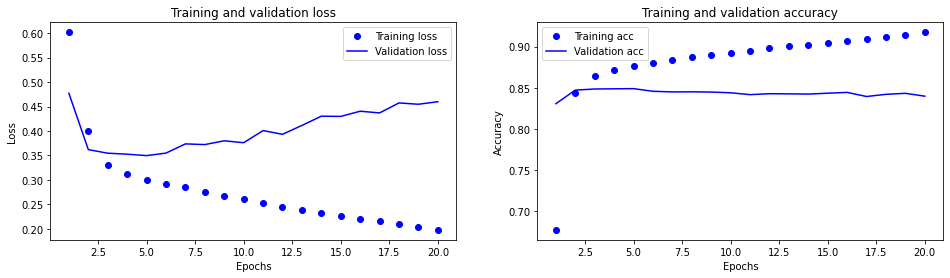

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- Training and validation loss를 통해 몇 epoch까지의 트레이닝이 적절한지 최적점 추정
- validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더 이상의 트레이닝은 무의미
#### (분석) epoch 4에서 최적

### 5-2. 1-D Convolution Neural Network(1-D CNN) 모델 

In [16]:
#vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
#word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#### 모델 훈련

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
210/210 [==============================] - 3s 6ms/step - loss: 0.5420 - accuracy: 0.7189 - val_loss: 0.3680 - val_accuracy: 0.8414
Epoch 2/10
210/210 [==============================] - 1s 5ms/step - loss: 0.3423 - accuracy: 0.8548 - val_loss: 0.3464 - val_accuracy: 0.8500
Epoch 3/10
210/210 [==============================] - 1s 5ms/step - loss: 0.3062 - accuracy: 0.8726 - val_loss: 0.3455 - val_accuracy: 0.8515
Epoch 4/10
210/210 [==============================] - 1s 5ms/step - loss: 0.2795 - accuracy: 0.8847 - val_loss: 0.3478 - val_accuracy: 0.8525
Epoch 5/10
210/210 [==============================] - 1s 5ms/step - loss: 0.2552 - accuracy: 0.8979 - val_loss: 0.3528 - val_accuracy: 0.8507
Epoch 6/10
210/210 [==============================] - 1s 5ms/step - loss: 0.2281 - accuracy: 0.9107 - val_loss: 0.3696 - val_accuracy: 0.8486
Epoch 7/10
210/210 [==============================] - 1s 5ms/step - loss: 0.2001 - accuracy: 0.9242 - val_loss: 0.3912 - val_accuracy: 0.8453
Epoch 

#### 모델 평가 (테스트셋)

In [18]:
results = model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 2s - loss: 0.5274 - accuracy: 0.8299


#### Loss, Accuracy 시각화

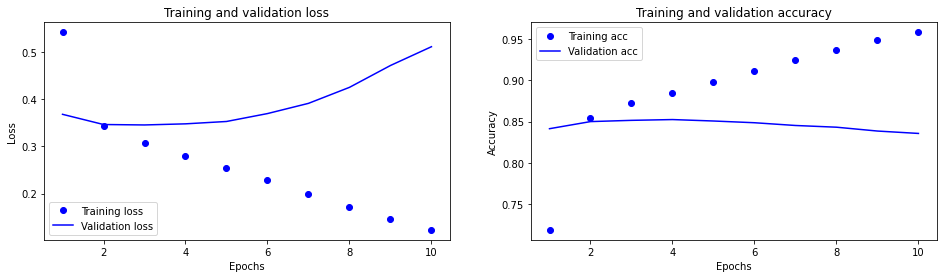

In [19]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### (분석) epoch 3에서 최적

### 5-3. GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [20]:
#vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
#word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


#### 모델 훈련

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
210/210 [==============================] - 1s 4ms/step - loss: 0.6097 - accuracy: 0.7540 - val_loss: 0.4720 - val_accuracy: 0.8121
Epoch 2/10
210/210 [==============================] - 1s 3ms/step - loss: 0.4016 - accuracy: 0.8323 - val_loss: 0.3722 - val_accuracy: 0.8365
Epoch 3/10
210/210 [==============================] - 1s 4ms/step - loss: 0.3372 - accuracy: 0.8568 - val_loss: 0.3570 - val_accuracy: 0.8432
Epoch 4/10
210/210 [==============================] - 1s 4ms/step - loss: 0.3062 - accuracy: 0.8718 - val_loss: 0.3545 - val_accuracy: 0.8453
Epoch 5/10
210/210 [==============================] - 1s 3ms/step - loss: 0.2838 - accuracy: 0.8826 - val_loss: 0.3571 - val_accuracy: 0.8463
Epoch 6/10
210/210 [==============================] - 1s 4ms/step - loss: 0.2658 - accuracy: 0.8911 - val_loss: 0.3624 - val_accuracy: 0.8458
Epoch 7/10
210/210 [==============================] - 1s 4ms/step - loss: 0.2506 - accuracy: 0.8994 - val_loss: 0.3705 - val_accuracy: 0.8451
Epoch 

#### 모델 평가 (테스트셋)

In [22]:
results = model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 2s - loss: 0.4108 - accuracy: 0.8346


#### Loss, Accuracy 시각화

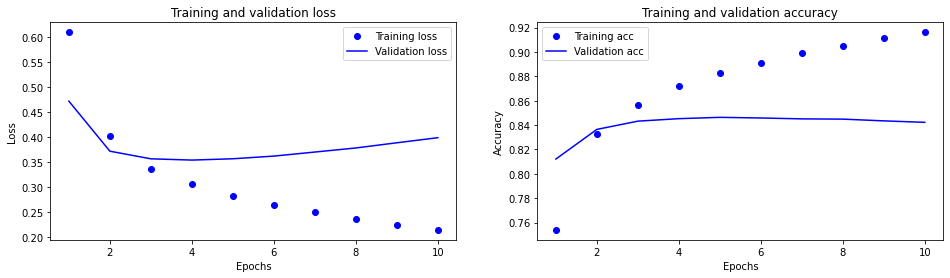

In [23]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### (분석) epoch 5에서 최적

### 3개 모델 실행 결과 비교

|  | RNN | 1-D CNN | MaxPool 1D |
|:----:|----|----|----|
| 테스트 Loss     | 0.4742 | 0.5274 | 0.4108 |
| 테스트 Accuracy | **0.8352** | 0.8299 | 0.8346 |
| Validation Loss | 0.3498 | 0.3478 | 0.3571 |
| Validation Accuracy | 0.8488 | **0.8525** | 0.8463 |
| 최적 Epoch 수 | 5 | 4| 5 |

[분석]
1. (정확도) 
  - 세 가지 모델 중 MaxPool 1D가 제일 높은 테스트 정확도(0.8327)를 보임
  - 그러나 세 모델 모두 실습 목적에 따라 간단히 구성하였으므로 전반적으로 정확도가 낮음
  - 모델 레이어를 늘린다면 정확도가 올라갈 것으로 예상함
2. (Vadiadation Accuracy/Loss와 Test Accuracy/Loss 차이)
  - MaxPool 1D에서 가장 작은 차이를 보임
  - 세 모델 모두에서 전반적으로 차이가 0.02 정도이므로 Validation 데이터셋 구성은 문제가 없어 보임
3. (Epoch 수)
  - 세 모델의 최적 Epoch 수는 4, 3, 5임
4. (결과값 변동)
  - Random State를 지정하지 않은 관계로 실행시마다 결과값의 변동이 있음

## 6) 학습된 Embedding 레이어 분석

- 워드 벡터 파일을 저장할 디렉터리 생성<br> 
- 워드 벡터를 다루는데 유용한 gensim 패키지 버전 확인

In [24]:
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

In [25]:
# 임베딩 레이어 차원 확인
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [26]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용

In [27]:
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

#### 단어 유사도 확인

- (재미있는 실험) 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하는 방법
  - 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인
  - gensim을 사용하면 아래와 같이 해볼 수 있습니다

In [28]:
# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("사랑")

[('재', 0.8285738229751587),
 ('큰', 0.8227742910385132),
 ('생전', 0.8185660243034363),
 ('되게', 0.8173596858978271),
 ('끼칠', 0.816320538520813),
 ('드러낸', 0.8149875998497009),
 ('감탄사', 0.8120585083961487),
 ('만날', 0.8107137680053711),
 ('테러리스트', 0.8102813959121704),
 ('lt', 0.8090978860855103)]

**[분석]**
- '사랑'이라는 단어의 유사도 확인 결과
- 추천된 단어들의 유사도는 0.81 이상임 (실행 때마다 결과가 다름)
- 그러나 단어들을 살펴보면 별 관련 없는 단어들이 있음
- 학습이 덜 되어서 워드벡터가 아직 덜 유의미한 것으로 보임

## 7) 한국어 Word2Vec 임베딩 활용하여 성능 개선
 
- 한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.
  - Pre-trained word vectors of 30+ languages(https://github.com/Kyubyong/wordvectors)
  - 위 링크에서 적절한 ko.bin을 찾아 이용하세요.
  - **/aiffel/sentiment_classification/data/ko.bin 에 다운로드**
  

- gensim 버전을 3.x.x로 낮춰야 오류가 나지 않습니다.
  - **현재 설치된 버전은 4.1.2**
  - **클라우드 셸에서 \$ conda install gensim==3.8.3 명령어 실행**

In [29]:
# gensim 패키지 버전 알아보기
import gensim
gensim.__version__

'3.8.3'

#### 한국어 Word2Vec 모델 적용 

In [30]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector.shape

/tmp/ipykernel_2698/1025019223.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['영화']


(200,)

#### 단어 유사도 확인

In [31]:
# 유사한 단어와 그 유사도 확인
word2vec.wv.most_similar("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [32]:
#하나 더...
word2vec.wv.most_similar("인공지능")

[('컴퓨팅', 0.6520194411277771),
 ('가상현실', 0.6393702030181885),
 ('심리학', 0.63037109375),
 ('모델링', 0.625065267086029),
 ('신경망', 0.6200424432754517),
 ('로봇', 0.6109743118286133),
 ('시뮬레이션', 0.6101070642471313),
 ('지능', 0.6092983484268188),
 ('기술', 0.6087720990180969),
 ('기술인', 0.5957075953483582)]

**[분석]**
- (한국어 Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 의미적 유사도가 가까운 것이 서로 가깝게 제대로 학습된 것을 확인할 수 있습니다.)
- 교재에 쓰여진 대로 의미적 유사도가 가까운 단어들을 확인할 수 있음
- 유사도 확률값은 상대적으로 낮음: 0.6 수준

### 한국어 Word2Vec 임베딩 활용
- 이전 스텝에서 학습했던 모델의 임베딩 레이어를 한국어 Word2Vec의 것으로 교체하여 다시 학습

In [33]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_2698/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_2698/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


#### 모델 구성
- 비교를 위해 앞에서 사용했던 모델과 같은 1D CNN 모델 사용

In [34]:
# 앞에서 사용했던 1D CNN 모델
#model = tf.keras.Sequential()
#model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
#model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
#model.add(tf.keras.layers.MaxPooling1D(5))
#model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
#model.add(tf.keras.layers.GlobalMaxPooling1D())
#model.add(tf.keras.layers.Dense(8, activation='relu'))
#model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# 모델 구성 - 비교를 위해 앞과 동일한 1D CNN 사용
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

#### 모델 훈련

In [35]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
210/210 [==============================] - 3s 8ms/step - loss: 0.5785 - accuracy: 0.6869 - val_loss: 0.4681 - val_accuracy: 0.7825
Epoch 2/10
210/210 [==============================] - 1s 6ms/step - loss: 0.4145 - accuracy: 0.8121 - val_loss: 0.3971 - val_accuracy: 0.8234
Epoch 3/10
210/210 [==============================] - 1s 6ms/step - loss: 0.3485 - accuracy: 0.8490 - val_loss: 0.3671 - val_accuracy: 0.8384
Epoch 4/10
210/210 [==============================] - 1s 6ms/step - loss: 0.3073 - accuracy: 0.8716 - val_loss: 0.3629 - val_accuracy: 0.8425
Epoch 5/10
210/210 [==============================] - 1s 6ms/step - loss: 0.2793 - accuracy: 0.8851 - val_loss: 0.3628 - val_accuracy: 0.8445
Epoch 6/10
210/210 [==============================] - 1s 6ms/step - loss: 0.2547 - accuracy: 0.8973 - val_loss: 0.3767 - val_accuracy: 0.8424
Epoch 7/10
210/210 [==============================] - 1s 6ms/step - loss: 0.2313 - accuracy: 0.9090 - val_loss: 0.3838 - val_accuracy: 0.8428
Epoch 

#### 모델 평가

In [36]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.4617 - accuracy: 0.8344


#### [결과 정리]

|  | RNN | 1-D CNN | MaxPool 1D | ***한국어 Word2Vec 사용 <br> 1D CNN*** |
|:----:|----|----|----|:----:|
| 테스트 Loss          | 0.4742 | 0.5274 | 0.4108 | *0.4617* |
| **테스트 Accuracy** | **0.8352** | 0.8299 | 0.8346 | ***0.8344*** |
| Validation Loss      | 0.3498 | 0.3478 | 0.3571 | *0.3628* |
| Validation Accuracy  | 0.8488 | **0.8525** | 0.8463 | *0.8445* |
| 최적 Epoch 수        | 5 | 4 | 5 | *5* |

[분석]
- Word2Vec을 정상적으로 잘 활용하면 그렇지 않은 경우보다 5% 이상의 성능 향상이 발생한다고 함 (교재)
- 위의 경우 성능 (테스트 Accuracy) 향상이 거의 이루어지지 않음
- 적절한 모델 구성, 하이퍼파라미터를 고려하여 감정 분석 모델의 성능을 최대한으로 끌어올려 봅시다
  - **모델을 RNN으로 바꾸고 모델 튜닝**

In [43]:
# 모델 구성 - RNN 사용
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
210/210 [==============================] - 5s 16ms/step - loss: 0.5914 - accuracy: 0.6394 - val_loss: 0.4680 - val_accuracy: 0.7627
Epoch 2/8
210/210 [==============================] - 3s 15ms/step - loss: 0.3797 - accuracy: 0.8302 

#### [결과 정리]

|  | RNN | 1-D CNN | MaxPool 1D | ***한국어 Word2Vec 사용 <br> 1D CNN*** | ***한국어 Word2Vec 사용*** <br> ***RNN*** <br> ***LSTM state vector=128*** |
|:----:|----|----|----|:----:|:----:|
| 테스트 Loss          | 0.4742 | 0.5274 | 0.4108 | *0.4617* | *0.3751* |
| **테스트 Accuracy** | **0.8352** | 0.8299 | 0.8346 | ***0.8344*** | ***0.8561***| 
| Validation Loss      | 0.3498 | 0.3478 | 0.3571 | *0.3628* | *0.3309* |
| Validation Accuracy | 0.8488 | **0.8525** | 0.8463 | *0.8445* | *0.8626*|
| 최적 Epoch 수       | 5 | 4 | 5 | *5* | *6* |

[분석]
- 모델을 가장 널리 쓰이는 RNN으로 바꾸고 모델 튜닝
- RNN인 LSTM 레이어의 LSTM state 벡터의 차원 수를 (8에서) 128로 변경
  - 차원 수를 16, 32, 64로 늘릴 때마다 정확도 향상
- 정확도 85% 이상 달성되어 종료!

#### Loss, Accuracy 시각화

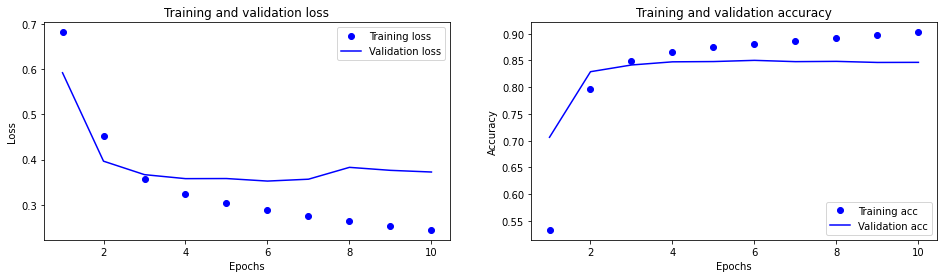

In [38]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

| 평가문항 | 상세기준 | 실행 내용 |
|:----|:----|:----:|
|1. 다양한 방법으로 Text Classification <br> 태스크를 성공적으로 구현하였다.| 3가지 이상의 모델이 성공적으로 시도됨 | 실행 |
|2. gensim을 활용하여 자체학습된 혹은 <br> 사전학습된 임베딩 레이어를 분석하였다.|gensim의 유사단어 찾기를 활용하여<br>  자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함| 실행|
|3. 한국어 Word2Vec을 활용하여 가시적인 <br> 성능향상을 달성했다.|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함| 달성| 

